In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest
from skimage.measure import compare_psnr

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

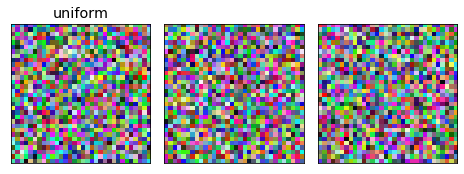

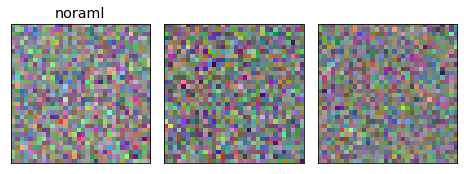

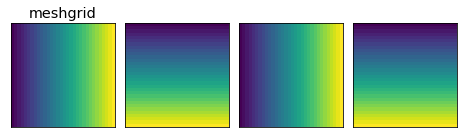

In [2]:
# Testing input generation
import utils
import input_gen as in_gen

# Uniform noise
imgs = []
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
fig, axes = utils.tensors_as_images(imgs, titles=['uniform'])

# Normal noise
imgs = []
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
fig, axes = utils.tensors_as_images(imgs, titles=['noraml'])

# Meshgrid
imgs = []
meshgrid_input = in_gen.get_noise(3, 32, 32, 'meshgrid')
imgs.append(meshgrid_input[0].unsqueeze(dim=0))
imgs.append(meshgrid_input[1].unsqueeze(dim=0))
meshgrid_input = in_gen.get_noise(3, 32, 32, 'meshgrid')
imgs.append(meshgrid_input[0].unsqueeze(dim=0))
imgs.append(meshgrid_input[1].unsqueeze(dim=0))
fig, axes = utils.tensors_as_images(imgs, titles=['meshgrid'])



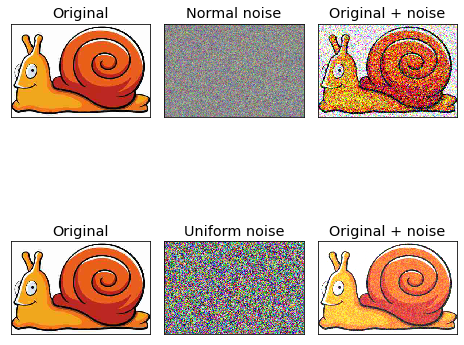

In [3]:
# Testing adding noise to image
from utils import *
from input_gen import *

fname_snail = 'data/denoising/snail.jpg'

img_pil = crop_image(get_image(fname_snail, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
img_noisy_normal, normal_noise = add_noise_to_tensor(img_tr, 'normal', std=0.3)
img_noisy_uniform, uniform_noise = add_noise_to_tensor(img_tr, 'uniform', std=0.3)
fig, axes = utils.tensors_as_images([img_tr, normal_noise, img_noisy_normal, img_tr,
                                     uniform_noise, img_noisy_uniform], 
                                    titles=['Original', 'Normal noise', 'Original + noise',
                                            'Original', 'Uniform noise', 'Original + noise'], nrows=2,
                                   hspace=0)

In [4]:
from models import *
from models.unet import *

net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
          [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1], weight_std=1./30)
print(net)

UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): 

In [5]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 747803


In [11]:
# change IMAGE to jet for jet image or snail for snail image
IMAGE = 'jet'
fname_snail = 'data/denoising/snail.jpg'
fname_jet = 'data/denoising/F16_GT.png'
fname = fname_snail if IMAGE == 'snail' else fname_jet
use_noise = False if IMAGE == 'snail' else True
img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
target_img = img_tr
if use_noise:
    target_noisy_img, _ = add_noise_to_tensor(target_img, 'normal', std=0.1)
else:
    target_noisy_img = target_img
target_noisy_img = target_noisy_img.unsqueeze(dim=0)
net_input = get_noise(*img_tr.shape, method='noise').unsqueeze(dim=0).detach()
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 2400
show_every = 100
optimizer = torch.optim.Adam(parameters, lr=LR)
for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out, target_noisy_img)
    loss.backward()
    psnr_noisy = compare_psnr(target_noisy_img.detach().cpu().numpy()[0], out.detach().cpu().numpy()[0])
    optimizer.step()
    if i % show_every == 0:
        print(f'Iteration {i}   Loss = {loss.item()}   PSNR_noisy = {psnr_noisy}')
print(f'Done training final Loss = {loss.item()}   PSNR_noisy = {psnr_noisy}')

Iteration 0   Loss = 0.06377983093261719
Iteration 50   Loss = 0.018300849944353104
Iteration 100   Loss = 0.016160881146788597
Iteration 150   Loss = 0.015251532196998596
Iteration 200   Loss = 0.014420284889638424
Iteration 250   Loss = 0.014211663976311684
Iteration 300   Loss = 0.013294721953570843
Iteration 350   Loss = 0.012961656786501408
Iteration 400   Loss = 0.012766589410603046
Iteration 450   Loss = 0.0126516567543149
Iteration 500   Loss = 0.012238687835633755
Iteration 550   Loss = 0.012082197703421116
Iteration 600   Loss = 0.012032195925712585
Iteration 650   Loss = 0.012010392732918262
Iteration 700   Loss = 0.011918650008738041
Iteration 750   Loss = 0.011748619377613068
Iteration 800   Loss = 0.012029582634568214
Iteration 850   Loss = 0.011659537442028522
Iteration 900   Loss = 0.011528830043971539
Iteration 950   Loss = 0.011538923718035221
Done training final Loss = 0.01161186583340168


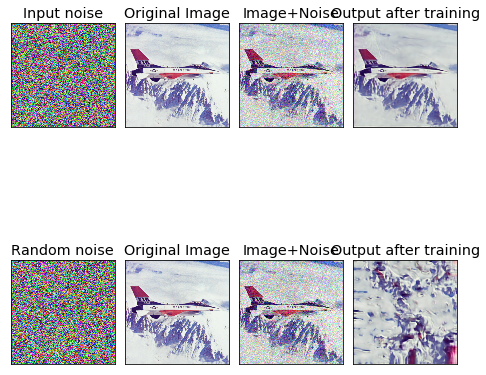

In [13]:
# Showing result of the training using original noise and random noise
original_noise = net_input
output1 = net(original_noise).detach()
output1 = output1.squeeze(dim=0)
random_noise = get_noise(*net_input.shape[1:], method='noise').unsqueeze(dim=0)
output2 = net(random_noise).detach()
output2 = output2.squeeze(dim=0)
fig, axes = utils.tensors_as_images([original_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output1, 
                                     random_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output2], 
                                    titles=['Input noise', 'Original Image', 'Image+Noise', 'Output after training', 
                                           'Random noise', 'Original Image', 'Image+Noise', 'Output after training'], nrows=2)
output_pil = np_to_pil(output1.detach().cpu().numpy())
output_pil.save(f'results/denoising/{IMAGE}.png')
# will need to use original noise to do denoising